<a href="https://colab.research.google.com/github/DM2003/DEEP-LEARNING-PROJECTS/blob/main/PAMAP_2_LSTM_PART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O pamap2.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
!unzip pamap2.zip

--2024-07-23 11:19:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘pamap2.zip’

pamap2.zip              [           <=>      ] 656.29M  17.9MB/s    in 19s     

2024-07-23 11:19:48 (34.8 MB/s) - ‘pamap2.zip’ saved [688167640]

Archive:  pamap2.zip
  inflating: PAMAP2_Dataset/Protocol/subject101.dat  
  inflating: PAMAP2_Dataset/Protocol/subject102.dat  
  inflating: PAMAP2_Dataset/Protocol/subject103.dat  
  inflating: PAMAP2_Dataset/Protocol/subject104.dat  
  inflating: PAMAP2_Dataset/Protocol/subject105.dat  
  inflating: PAMAP2_Dataset/Protocol/subject106.dat  
  inflating: PAMAP2_Dataset/Protocol/subject107.dat  
  inflating: PAMAP2_Dataset/Protocol/subject108.dat  
  inflating: PAMAP2_Dataset/Protocol/sub

In [ ]:
import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

In [ ]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [ ]:
def generate_three_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    return [x, y, z]

def generate_four_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    w = name + '_w'
    return [x, y, z, w]

def generate_cols_IMU(name):
    # temp
    temp = name + '_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name + '_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name + '_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name + '_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name + '_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # orientation
    orientation = name + '_4D_orientation'
    orientation = generate_four_IMU(orientation)
    output.extend(orientation)
    return output

def load_IMU():
    output = ['time_stamp', 'activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

def load_subjects(root='/content/PAMAP2_Dataset/Protocol/subject'):
    all_subjects = []
    cols = load_IMU()

    for i in range(101, 110):
        path = root + str(i) + '.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols
        subject['id'] = i
        all_subjects.append(subject)

    output = pd.concat(all_subjects, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [ ]:
data.head(5)

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


In [ ]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [ ]:
data.describe()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,...,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,...,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,1.045664e+02
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,...,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,...,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,1.426340e-01,-6.129580e-01,4.914657e-03,-5.378710e-01,1.020000e+02
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,...,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,1.050000e+02
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577087e-01,6.453505e+00,6.531523e+00,-9.058870e-01,6.458670e+00,6.775980e+00,...,1.162570e-01,9.181807e-02,-1.790600e+01,1.783892e+01,3.121160e+01,5.600202e-01,6.153723e-01,5.960633e-01,4.382870e-01,1.070000e+02
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,1.090000e+02


In [ ]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of uniqe activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  9
Numbe of uniqe activitys in the data:  12


In [ ]:
activity_map = load_activity_map()

In [ ]:
# Getting target attribute
target = data["activity_id"]
data.drop(["activity_id"], axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=9)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_scale = x_train.columns.difference(['time_stamp'])

In [ ]:
x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_test[columns_to_scale] = scaler.transform(x_test[columns_to_scale])

In [ ]:
# Verify the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (1457154, 54)
x_test shape: (485718, 54)
y_train shape: (1457154,)
y_test shape: (485718,)


In [ ]:
# Reshape data for LSTM
window_size = 100  # Define your window size
samples = len(x_train) // window_size

In [ ]:
x_train_reshaped = x_train[:samples * window_size].values.reshape((samples, window_size, x_train.shape[1]))
y_train_reshaped = y_train[:samples * window_size].values.reshape((samples, window_size))[:, 0]

In [ ]:
samples_test = len(x_test) // window_size
x_test_reshaped = x_test[:samples_test * window_size].values.reshape((samples_test, window_size, x_test.shape[1]))
y_test_reshaped = y_test[:samples_test * window_size].values.reshape((samples_test, window_size))[:, 0]

In [ ]:
# Verify the shapes after reshaping
print(f"x_train_reshaped shape: {x_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"x_test_reshaped shape: {x_test_reshaped.shape}")
print(f"y_test_reshaped shape: {y_test_reshaped.shape}")


x_train_reshaped shape: (14571, 100, 54)
y_train_reshaped shape: (14571,)
x_test_reshaped shape: (4857, 100, 54)
y_test_reshaped shape: (4857,)


In [ ]:
# Check the distribution of target labels using numpy
from collections import Counter
print("Train label distribution:")
train_label_counts = Counter(y_train_reshaped)
print(train_label_counts)

Train label distribution:
Counter({17: 1783, 4: 1743, 2: 1482, 3: 1423, 1: 1414, 7: 1407, 16: 1278, 6: 1245, 12: 898, 13: 802, 5: 717, 24: 379})


In [ ]:
print("Test label distribution:")
test_label_counts = Counter(y_test_reshaped)
print(test_label_counts)

Test label distribution:
Counter({4: 581, 17: 566, 2: 498, 7: 474, 3: 470, 6: 450, 1: 449, 16: 415, 12: 308, 13: 264, 5: 251, 24: 131})


In [ ]:
# Check unique values of the labels
print("Unique train labels:", np.unique(y_train_reshaped))
print("Unique test labels:", np.unique(y_test_reshaped))

Unique train labels: [ 1  2  3  4  5  6  7 12 13 16 17 24]
Unique test labels: [ 1  2  3  4  5  6  7 12 13 16 17 24]


In [ ]:
# Ensure there are no incorrect label values
valid_labels = set(load_activity_map().keys())
print("Invalid train labels:", set(y_train_reshaped) - valid_labels)
print("Invalid test labels:", set(y_test_reshaped) - valid_labels)

Invalid train labels: set()
Invalid test labels: set()


In [ ]:
# Verify the shapes after reshaping
print(f"x_train_reshaped shape: {x_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"x_test_reshaped shape: {x_test_reshaped.shape}")
print(f"y_test_reshaped shape: {y_test_reshaped.shape}")


x_train_reshaped shape: (14571, 100, 54)
y_train_reshaped shape: (14571,)
x_test_reshaped shape: (4857, 100, 54)
y_test_reshaped shape: (4857,)


In [ ]:
# Verify that labels are within the valid range
print("Maximum train label:", y_train_reshaped.max())
print("Maximum test label:", y_test_reshaped.max())


Maximum train label: 24
Maximum test label: 24


In [ ]:
# Verify that the input data has no NaN values
print("NaN values in x_train_reshaped:", np.isnan(x_train_reshaped).sum())
print("NaN values in x_test_reshaped:", np.isnan(x_test_reshaped).sum())

NaN values in x_train_reshaped: 0
NaN values in x_test_reshaped: 0


In [ ]:
# Ensure that the labels are integers and start from 0
label_encoder = {label: idx for idx, label in enumerate(sorted(activity_map.keys()))}
y_train_reshaped = np.array([label_encoder[label] for label in y_train_reshaped])
y_test_reshaped = np.array([label_encoder[label] for label in y_test_reshaped])

In [ ]:
# Normalize the input data
x_train_reshaped = x_train_reshaped / np.max(x_train_reshaped)
x_test_reshaped = x_test_reshaped / np.max(x_test_reshaped)


In [ ]:
# Define a more complex LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(activity_map), activation='softmax'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with a different batch size
history = model.fit(x_train_reshaped, y_train_reshaped, epochs=20, batch_size=32, validation_data=(x_test_reshaped, y_test_reshaped), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test_reshaped, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
456/456 [==============================] - 77s 36ms/step - loss: 2.4772 - accuracy: 0.1145 - val_loss: 2.0035 - val_accuracy: 0.2670
Epoch 2/20
456/456 [==============================] - 14s 30ms/step - loss: 1.2609 - accuracy: 0.4721 - val_loss: 0.8947 - val_accuracy: 0.6535
Epoch 3/20
456/456 [==============================] - 14s 30ms/step - loss: 0.8341 - accuracy: 0.6436 - val_loss: 0.6625 - val_accuracy: 0.7486
Epoch 4/20
456/456 [==============================] - 14s 30ms/step - loss: 0.7661 - accuracy: 0.6729 - val_loss: 0.6142 - val_accuracy: 0.7525
Epoch 5/20
456/456 [==============================] - 15s 33ms/step - loss: 0.7252 - accuracy: 0.6961 - val_loss: 0.6124 - val_accuracy: 0.7280
Epoch 6/20
456/456 [==============================] - 14s 30ms/step - loss: 0.6952 - accuracy: 0.7096 - val_loss: 0.9989 - val_accuracy: 0.6323
Epoch 7/20
456/456 [==============================] - 15s 32ms/step - loss: 0.6828 - accuracy: 0.7158 - val_loss: 0.5532 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt

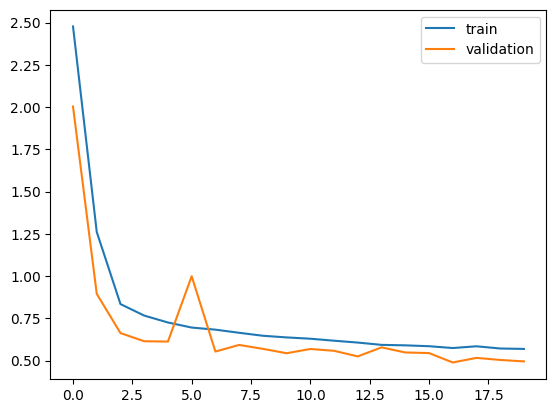

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()




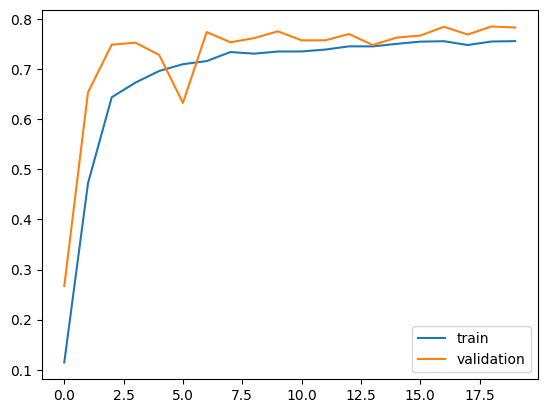

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()